In [1]:
from Funcs.Utility import *

In [2]:
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'labels_1h_esmsyn.csv'), index_col=['pcode','timestamp'],parse_dates=True)
PARTICIPANTS = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'UserInfo.csv'),index_col = 'pcode')

In [3]:
p = os.path.join(PATH_INTERMEDIATE, 'calorie_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [4]:
X

,PIF#participationStartTimestamp,PIF#age,PIF#openness,PIF#conscientiousness,PIF#neuroticism,PIF#extraversion,PIF#agreeableness,PIF#GHQ12,PIF#PSS10,PIF#CESD-R,...,PWR#RLV_SUP_TodayAfternoon,PWR#ETP#_TodayLateAfternoon,PWR#ASC#_TodayLateAfternoon,PWR#RLV_SUP_TodayLateAfternoon,PWR#ETP#_TodayEvening,PWR#ASC#_TodayEvening,PWR#RLV_SUP_TodayEvening,PWR#ETP#_TodayNight,PWR#ASC#_TodayNight,PWR#RLV_SUP_TodayNight
0,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21614,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21615,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21616,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21617,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [6]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [7]:
X = X.loc[:, ~X.columns.str.startswith('LOC')]

In [8]:
cn = X.columns.tolist()
print(cn)

['PIF#participationStartTimestamp', 'Time#DOW=MON', 'Time#DOW=TUE', 'Time#DOW=WED', 'Time#DOW=THU', 'Time#DOW=FRI', 'Time#DOW=SAT', 'Time#DOW=SUN', 'Time#WKD=Y', 'Time#WKD=N', 'Time#HRN=DAWN', 'Time#HRN=MORNING', 'Time#HRN=AFTERNOON', 'Time#HRN=LATE_AFTERNOON', 'Time#HRN=EVENING', 'Time#HRN=NIGHT', 'Time#HRN=MIDNIGHT', 'APP_CAT#DSC', 'APP_CAT#DSC=UNKNOWNSYSTEMENTERSOCIALHEALTHWORKINFO', 'BAT_STA#DSC', 'BAT_STA#DSC=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_PLG#DSC', 'BAT_PLG#DSC=UNDEFINEDACUSBWIRELESS', 'CALL_CNT#DSC', 'CALL_CNT#DSC=UNKNOWNMOBILEOTHERWORKHOMEUNDEFINEDMAIN', 'SCR_EVENT#DSC', 'SCR_EVENT#DSC=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'RING#DSC', 'RING#DSC=VIBRATESILENTNORMAL', 'CHG#DSC', 'CHG#DSC=DISCONNECTED', 'CHG#DSC=CONNECTED', 'BT_BondState#DSC', 'BT_BondState#DSC=NONEBONDEDBONDING', 'BT_DeviceType#DSC', 'BT_DeviceType#DSC=LECLASSICUNDEFINEDDUAL', 'BT_classType#DSC', 'BT_classType#DSC=UNDEFINEDPHONE_SMARTWEARABLE_WRIST_WATCHCOMPUTER_LAPTOPAUDIO_VIDEO_SET_TOP_BOXAUDIO_VIDEO_HA

In [9]:
unique_parts = set()
for col in cn:
    part = col.split('#')[0]  # Get the part before the first '#'
    unique_parts.add(part)

# Print the unique parts
print(unique_parts)

{'CALL_CNT', 'BAT_STA', 'APP_DUR_UNKNOWN', 'BAT_PLG', 'SCR_EVENT', 'Notification_CAT', 'MSG_SNT', 'Time', 'APP_CAT', 'CALL_DUR', 'INST_JAC', 'DATA_MRCV', 'PIF', 'BT_classType', 'Sleep', 'DATA_SNT', 'BT_DeviceType', 'MSG_ALL', 'PWR', 'SCR_DUR', 'BT_BondState', 'DATA_RCV', 'BAT_LEV', 'CHG', 'DATA_MSNT', 'Notification_VIS', 'BAT_TMP', 'RING', 'MSG_RCV', 'Dozemode'}


In [10]:
columns_with_loc = [col for col in cn if 'LOC' in col]

In [11]:
columns_with_loc

[]

In [12]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

normalize =True
# Feature selection method
selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )  
    )
select = [clone(selector)]
oversample = True

In [13]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test

def process_dataframe(X):
    """
    Process the input DataFrame 'X':
    1. Set column names as a range from 0 to the number of columns.
    2. Replace boolean values with 1 for True and 0 for False.

    Parameters:
        X (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The processed DataFrame.
    """
    # Set column names as a range from 0 to the number of columns
    X.columns = range(X.shape[1])

    # Replace boolean values with 1 for True and 0 for False
#     X = X * 1

    return X

def save_data_to_data_file(X, y, filename):
    if not os.path.exists(PATH_SAVE_CALORIES):
        os.makedirs(PATH_SAVE_CALORIES)

    file_path = os.path.join(PATH_SAVE_CALORIES, filename)

    with open(file_path, 'w') as f:
        for i in range(len(X)):
            # Check if y is a numpy array or dataframe
            label = y[i] if isinstance(y, np.ndarray) else y.iloc[i].values[0]
            
            # Start building the line with the label
            line = str(label)
            
            # Iterate through columns of X
            for col_idx, value in enumerate(X[i] if isinstance(X, np.ndarray) else X.iloc[i]):
                line += " {}:{}".format(col_idx, value)
            
            f.write(line + '\n')

In [14]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test



# @ray.remote
# # def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
# def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file):
#     X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    
# #     # Use LOSO to split the training set further into training and evaluation sets
# #     loso = LeaveOneGroupOut()
# #     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
# #     X_eval, y_eval = X_train.iloc[eval_indices], y_train[eval_indices]
# #     X_train, y_train = X_train.iloc[train_indices], y_train[train_indices]
    
#     # Split 20% of training set as eval set
#     X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# #     # Split 20% of training set as eval set based on groups
# #     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
# #     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
# #     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
# #     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]
    
#     # Apply SMOTENC
#     smote_nc = SMOTENC(categorical_features=get_categorical_features_indices(X_train), random_state=RANDOM_STATE)
#     X_train, y_train = smote_nc.fit_resample(X_train, y_train)
    
# #     #Removing low variance features
# #     X_train = exclude_low_variance(X_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

# #     #Removing highly correlated features
# #     X_train = remove_pairwise_corr(X_train, outcome_variable= y_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set
    
#     # Capture indices 
#     train_indices = X_train.index
#     eval_indices = X_eval.index
#     test_indices = X_test.index
    
#     # Before feature selection, capture the columns
#     current_columns = X_train.columns
    
#     # Feature selection
#     selector = feature_selector(X_train, y_train)
#     X_train = selector.transform(X_train)
#     X_eval = selector.transform(X_eval)
#     X_test = selector.transform(X_test)

#     # Use the captured columns to get the selected columns
#     selected_columns = current_columns[selector.get_support()]
    
#     X_train = pd.DataFrame(X_train, columns=selected_columns, index=train_indices)
#     X_eval = pd.DataFrame(X_eval, columns=selected_columns, index=eval_indices)
#     X_test = pd.DataFrame(X_test, columns=selected_columns, index=test_indices)

    
#     # Process dataframes
#     X_train = process_dataframe(X_train)
#     X_eval = process_dataframe(X_eval)
#     X_test = process_dataframe(X_test)

#     subject = all_groups[test_idx[0]]

#     save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
#     save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
#     save_data_to_data_file(X_test, y_test, f'{subject}_val.data')

@ray.remote
def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
    X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    

#     #Leave n subject out
#     n = 4  # Number of groups to leave out
#     # Use LNGO to split the training set further into training and evaluation sets
#     lngo = LeavePGroupsOut(n_groups=n)
#     train_indices, eval_indices = next(lngo.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()

    
#     # Use LOSO to split the training set further into training and evaluation sets
#     loso = LeaveOneGroupOut()
#     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()


#     # Initialize the stratified group k-fold splitter
#     sgkf = StratifiedGroupKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
#     # Get the train and eval indices
#     train_inds, eval_inds = next(sgkf.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    
    # Split 20% of training set as eval set
    X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE,  stratify=y_train)

#     # Split 20% of training set as eval set based on groups
#     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
#     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    if normalize:
        # Normalize numeric features
        scaler = StandardScaler().fit(X_train[C_num])
        X_train[C_num] = scaler.transform(X_train[C_num].copy())
        X_eval[C_num] = scaler.transform(X_eval[C_num].copy())
        X_test[C_num] = scaler.transform(X_test[C_num].copy())

    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            # Fit feature selector only on training data
            s.fit(X_train, y_train)
            selected_features = X_train.columns[s.get_support()]
            
            # Apply feature selection to train, eval, and test
            X_train = X_train[selected_features].copy()
            X_eval = X_eval[selected_features].copy()
            X_test = X_test[selected_features].copy()

    if oversample:
        # Determine categorical features for SMOTENC
        if len(C_cat):
            M = np.isin(X_train.columns, C_cat)
            sampler = SMOTENC(categorical_features=M, random_state=seed)
        else:
            sampler = SMOTE(random_state=seed)
        # Only oversample training data
        X_train, y_train = sampler.fit_resample(X_train, y_train)
    
    # Apply consistent processing to train, eval, and test dataframes
    X_train = process_dataframe(X_train)
    X_eval = process_dataframe(X_eval)
    X_test = process_dataframe(X_test)

    subject = all_groups[test_idx[0]]

    # Save processed data to files
    save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
    save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
    save_data_to_data_file(X_test, y_test, f'{subject}_val.data')


In [15]:
# Create a full dataset and corresponding labels and groups
all_data = X
all_labels = y
all_groups = groups

In [16]:
cv_strategy = 'loso'  # Choose from: 'loso', 'group_k_fold', 'k_fold', 'time_series'

with on_ray():
    # Get the relevant train-test splits based on the chosen CV strategy
    splits = get_cv_splits(cv_strategy, all_data, all_labels, all_groups)
    
    C_cat = np.asarray(sorted(cats))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))
#    Iterate over train-test splits
    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select) 
#    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file)
                                         for train_idx, test_idx in splits]

    ray.get(futures)

2024-08-13 12:11:30,770	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(process_and_save_split pid=79623) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=79623) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=79623) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=79623) 
(process_and_save_split pid=79623) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_and_save_split pid=79626) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning:  [repeated 16x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(process_and_save_split pid=79626) A value is trying to be 

(process_and_save_split pid=79620) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=79620) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=79620) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=79620) 
(process_and_save_split pid=79620) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_and_save_split pid=79618) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=79618) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=79618) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=79618) 
(process_and_save_split pid=79618) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

(process_and_save_split pid=79624) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=79624) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=79624) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(process_and_save_split pid=79624)  [repeated 2x across cluster]
(process_and_save_split pid=79624) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]
(process_and_save_split pid=79612) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=79612) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=79612) Try using .loc[row_indexer,col_indexer] = value instead [re

(process_and_save_split pid=79621) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=79621) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=79621) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(process_and_save_split pid=79621)  [repeated 2x across cluster]
(process_and_save_split pid=79621) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]
(process_and_save_split pid=79626) /tmp/ipykernel_79378/632661198.py:203: SettingWithCopyWarning:  [repeated 5x across cluster]
(process_and_save_split pid=79626) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 5x across cluster]
(process_and_save_split pid=79626) Try using .loc[row_indexer,col_indexer] = value instead [re

Training

In [17]:
param = {
    "learning_rate": 0.01,
    "seed": RANDOM_STATE,
    "objective": 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
}

In [18]:
import xgboost as xgb
import random
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             log_loss, accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)
import numpy as np
import os
import pickle
import ray
import pandas as pd
from sklearn.datasets import load_svmlight_file
from xgboost import DMatrix


def mkdir(path):
    path = path.strip()
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False

def find_best_threshold(y_true, y_probs):
    best_threshold = 0
    best_f1 = 0
    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    return best_threshold

random.seed(seed)

folder = PATH_RESULTS
mkdir(folder)
data_folder = PATH_SAVE_CALORIES

final_total_auc = np.empty(0)
final_total_logloss = np.empty(0)
final_total_f1_macro = np.empty(0)
final_total_f1_pos_label = np.empty(0)
final_total_accuracy = np.empty(0)
final_total_precision = np.empty(0)
final_total_recall = np.empty(0)
train_aucs = []
test_aucs = []



# @ray.remote
def train_and_evaluate(subject, param, data_folder):

    print("start training & evaluation for {}".format(subject))


    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(data_folder + '{}_train.data'.format(subject))
    dtest = xgb.DMatrix(data_folder + '{}_val.data'.format(subject))
    deval = xgb.DMatrix(data_folder + '{}_eval.data'.format(subject))
    

    evallist = [(dtrain, 'train'), (deval, 'eval')]

    # Train the model using standard xgboost
    bst = xgb.train(param, dtrain, evals=evallist, early_stopping_rounds=10)
    
    y_real = dtest.get_label()  # Use the labels directly
    y_score = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
#     y_score = bst.predict(dtest)
#     best_threshold = find_best_threshold(y_real, y_score)
#     y_pred = [1 if score >= best_threshold else 0 for score in y_score]
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]

    all_roc_auc = roc_auc_score(y_true=y_real, y_score=y_score, average=None)
    all_logloss = log_loss(y_real, y_score)
    accuracy = accuracy_score(y_real, y_pred)

    pre, rec, f1, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='macro', zero_division=0)
    precision = pre
    recall = rec
    f1_macro = f1

    _, _, f1_pos, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='binary', zero_division=0)
    f1_pos_label = f1_pos
    print("finish training & evaluation for {}".format(subject))

#     return subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label

    ###############################
    # Compute training AUC
    y_train_real = dtrain.get_label()
    y_train_score = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit)
    train_auc = roc_auc_score(y_true=y_train_real, y_score=y_train_score)
    
    test_auc = all_roc_auc

    return subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label
 
with on_ray():
    results = [train_and_evaluate(subject, param, data_folder) for subject in set(all_groups)]
#     futures = [train_and_evaluate.remote(subject, param, data_folder) for subject in combined_similarity['pcode'].unique()]
#     results = ray.get(futures)

    for result in results:
         #Retrieving training AUC
        subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        train_aucs.append(train_auc)
        test_aucs.append(test_auc)
        
#         subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        # Append to final metric arrays
#         final_total_auc = np.append(final_total_auc, all_roc_auc)

        final_total_logloss = np.append(final_total_logloss, all_logloss)
        final_total_accuracy = np.append(final_total_accuracy, accuracy)
        final_total_precision = np.append(final_total_precision, precision)
        final_total_recall = np.append(final_total_recall, recall)
        final_total_f1_macro = np.append(final_total_f1_macro, f1_macro)
        final_total_f1_pos_label = np.append(final_total_f1_pos_label, f1_pos_label)

    print("TOTAL All round, ROCAUC{}, LOGLOSS{}, ACCURACY{}, PRECISION{}, RECALL{}, F1 MACRO{}, F1 POSITIVE LABEL{},\n".format(np.mean(test_aucs), np.mean(final_total_logloss), np.mean(final_total_accuracy), np.mean(final_total_precision), np.mean(final_total_recall), np.mean(final_total_f1_macro), np.mean(final_total_f1_pos_label)))

2024-08-13 12:20:23,984	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


start training & evaluation for P078
[0]	train-auc:0.78840	eval-auc:0.73296
[1]	train-auc:0.78918	eval-auc:0.73345
[2]	train-auc:0.79171	eval-auc:0.73435
[3]	train-auc:0.79907	eval-auc:0.73975
[4]	train-auc:0.80504	eval-auc:0.74456
[5]	train-auc:0.80429	eval-auc:0.74403
[6]	train-auc:0.80559	eval-auc:0.74529
[7]	train-auc:0.80772	eval-auc:0.74734
[8]	train-auc:0.80790	eval-auc:0.74684
[9]	train-auc:0.80889	eval-auc:0.74840
finish training & evaluation for P078
start training & evaluation for P010


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79084	eval-auc:0.72422
[1]	train-auc:0.79120	eval-auc:0.72431
[2]	train-auc:0.79358	eval-auc:0.72490
[3]	train-auc:0.79312	eval-auc:0.72471
[4]	train-auc:0.79693	eval-auc:0.72753
[5]	train-auc:0.79989	eval-auc:0.72972
[6]	train-auc:0.80020	eval-auc:0.73064
[7]	train-auc:0.80303	eval-auc:0.73197
[8]	train-auc:0.80291	eval-auc:0.73220
[9]	train-auc:0.80451	eval-auc:0.73290
finish training & evaluation for P010
start training & evaluation for P008


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79216	eval-auc:0.73075
[1]	train-auc:0.79689	eval-auc:0.73280
[2]	train-auc:0.80008	eval-auc:0.73631
[3]	train-auc:0.80244	eval-auc:0.73686
[4]	train-auc:0.80202	eval-auc:0.73676
[5]	train-auc:0.80293	eval-auc:0.73727
[6]	train-auc:0.80480	eval-auc:0.73823
[7]	train-auc:0.80450	eval-auc:0.73880
[8]	train-auc:0.80439	eval-auc:0.73860
[9]	train-auc:0.80515	eval-auc:0.73928
finish training & evaluation for P008
start training & evaluation for P095


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78903	eval-auc:0.72913
[1]	train-auc:0.79112	eval-auc:0.73017
[2]	train-auc:0.79131	eval-auc:0.72976
[3]	train-auc:0.79405	eval-auc:0.73322
[4]	train-auc:0.79690	eval-auc:0.73424
[5]	train-auc:0.79712	eval-auc:0.73413
[6]	train-auc:0.79745	eval-auc:0.73459
[7]	train-auc:0.79777	eval-auc:0.73497
[8]	train-auc:0.80011	eval-auc:0.73740
[9]	train-auc:0.80345	eval-auc:0.73865
finish training & evaluation for P095
start training & evaluation for P045


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79216	eval-auc:0.72351
[1]	train-auc:0.79778	eval-auc:0.72685
[2]	train-auc:0.79852	eval-auc:0.72718
[3]	train-auc:0.80140	eval-auc:0.72938
[4]	train-auc:0.80499	eval-auc:0.73202
[5]	train-auc:0.80641	eval-auc:0.73381
[6]	train-auc:0.80769	eval-auc:0.73507
[7]	train-auc:0.80953	eval-auc:0.73672
[8]	train-auc:0.80943	eval-auc:0.73706
[9]	train-auc:0.81016	eval-auc:0.73777
finish training & evaluation for P045
start training & evaluation for P057


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79250	eval-auc:0.73087
[1]	train-auc:0.79433	eval-auc:0.73399
[2]	train-auc:0.79538	eval-auc:0.73482
[3]	train-auc:0.79547	eval-auc:0.73452
[4]	train-auc:0.79662	eval-auc:0.73682
[5]	train-auc:0.79724	eval-auc:0.73637
[6]	train-auc:0.79776	eval-auc:0.73742
[7]	train-auc:0.80135	eval-auc:0.73943
[8]	train-auc:0.80293	eval-auc:0.74067
[9]	train-auc:0.80425	eval-auc:0.74061
finish training & evaluation for P057
start training & evaluation for P054


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79096	eval-auc:0.71943
[1]	train-auc:0.79260	eval-auc:0.72156
[2]	train-auc:0.79299	eval-auc:0.72212
[3]	train-auc:0.79682	eval-auc:0.72619
[4]	train-auc:0.79774	eval-auc:0.72624
[5]	train-auc:0.79906	eval-auc:0.72860
[6]	train-auc:0.79957	eval-auc:0.72765
[7]	train-auc:0.80058	eval-auc:0.72953
[8]	train-auc:0.80094	eval-auc:0.72976
[9]	train-auc:0.80255	eval-auc:0.73232
finish training & evaluation for P054
start training & evaluation for P122


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79585	eval-auc:0.72365
[1]	train-auc:0.79948	eval-auc:0.72709
[2]	train-auc:0.80163	eval-auc:0.72987
[3]	train-auc:0.80406	eval-auc:0.73332
[4]	train-auc:0.80509	eval-auc:0.73465
[5]	train-auc:0.80478	eval-auc:0.73530
[6]	train-auc:0.80558	eval-auc:0.73606
[7]	train-auc:0.80582	eval-auc:0.73676
[8]	train-auc:0.80678	eval-auc:0.73706
[9]	train-auc:0.80747	eval-auc:0.73846
finish training & evaluation for P122
start training & evaluation for P098


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79091	eval-auc:0.72928
[1]	train-auc:0.79889	eval-auc:0.73668
[2]	train-auc:0.80099	eval-auc:0.73779
[3]	train-auc:0.80369	eval-auc:0.73920
[4]	train-auc:0.80396	eval-auc:0.74018
[5]	train-auc:0.80534	eval-auc:0.74079
[6]	train-auc:0.80564	eval-auc:0.74128
[7]	train-auc:0.80518	eval-auc:0.74170
[8]	train-auc:0.80573	eval-auc:0.74144
[9]	train-auc:0.80610	eval-auc:0.74160
finish training & evaluation for P098
start training & evaluation for P121


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79264	eval-auc:0.72562
[1]	train-auc:0.79927	eval-auc:0.73286
[2]	train-auc:0.79961	eval-auc:0.73410
[3]	train-auc:0.79980	eval-auc:0.73344
[4]	train-auc:0.80046	eval-auc:0.73412
[5]	train-auc:0.80378	eval-auc:0.73723
[6]	train-auc:0.80494	eval-auc:0.73827
[7]	train-auc:0.80595	eval-auc:0.73922
[8]	train-auc:0.80597	eval-auc:0.73917
[9]	train-auc:0.80681	eval-auc:0.73978
finish training & evaluation for P121
start training & evaluation for P051


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79338	eval-auc:0.73021
[1]	train-auc:0.79569	eval-auc:0.73281
[2]	train-auc:0.79645	eval-auc:0.73324
[3]	train-auc:0.79785	eval-auc:0.73372
[4]	train-auc:0.79785	eval-auc:0.73400
[5]	train-auc:0.79837	eval-auc:0.73444
[6]	train-auc:0.79949	eval-auc:0.73580
[7]	train-auc:0.80008	eval-auc:0.73569
[8]	train-auc:0.80241	eval-auc:0.73696
[9]	train-auc:0.80311	eval-auc:0.73773
finish training & evaluation for P051
start training & evaluation for P075


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78862	eval-auc:0.73497
[1]	train-auc:0.79021	eval-auc:0.73751
[2]	train-auc:0.79196	eval-auc:0.73980
[3]	train-auc:0.79671	eval-auc:0.74499
[4]	train-auc:0.79654	eval-auc:0.74430
[5]	train-auc:0.79646	eval-auc:0.74472
[6]	train-auc:0.79835	eval-auc:0.74609
[7]	train-auc:0.79840	eval-auc:0.74608
[8]	train-auc:0.79903	eval-auc:0.74590
[9]	train-auc:0.80008	eval-auc:0.74719
finish training & evaluation for P075
start training & evaluation for P104


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78971	eval-auc:0.74000
[1]	train-auc:0.79696	eval-auc:0.74270
[2]	train-auc:0.80260	eval-auc:0.74474
[3]	train-auc:0.80285	eval-auc:0.74566
[4]	train-auc:0.80453	eval-auc:0.74426
[5]	train-auc:0.80407	eval-auc:0.74399
[6]	train-auc:0.80411	eval-auc:0.74405
[7]	train-auc:0.80462	eval-auc:0.74461
[8]	train-auc:0.80561	eval-auc:0.74388
[9]	train-auc:0.80614	eval-auc:0.74432
finish training & evaluation for P104
start training & evaluation for P020


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79373	eval-auc:0.73025
[1]	train-auc:0.79917	eval-auc:0.73329
[2]	train-auc:0.79909	eval-auc:0.73471
[3]	train-auc:0.79976	eval-auc:0.73415
[4]	train-auc:0.80380	eval-auc:0.73863
[5]	train-auc:0.80461	eval-auc:0.73921
[6]	train-auc:0.80702	eval-auc:0.74278
[7]	train-auc:0.80714	eval-auc:0.74310
[8]	train-auc:0.80839	eval-auc:0.74381
[9]	train-auc:0.80882	eval-auc:0.74403
finish training & evaluation for P020
start training & evaluation for P052


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78788	eval-auc:0.72470
[1]	train-auc:0.79439	eval-auc:0.73148
[2]	train-auc:0.79480	eval-auc:0.73099
[3]	train-auc:0.79536	eval-auc:0.73240
[4]	train-auc:0.79574	eval-auc:0.73177
[5]	train-auc:0.79829	eval-auc:0.73251
[6]	train-auc:0.79874	eval-auc:0.73299
[7]	train-auc:0.80007	eval-auc:0.73451
[8]	train-auc:0.80057	eval-auc:0.73432
[9]	train-auc:0.80096	eval-auc:0.73464
finish training & evaluation for P052
start training & evaluation for P077


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79017	eval-auc:0.74328
[1]	train-auc:0.79264	eval-auc:0.74384
[2]	train-auc:0.79302	eval-auc:0.74514
[3]	train-auc:0.79371	eval-auc:0.74559
[4]	train-auc:0.79568	eval-auc:0.74699
[5]	train-auc:0.79745	eval-auc:0.74823
[6]	train-auc:0.79820	eval-auc:0.74838
[7]	train-auc:0.80266	eval-auc:0.74993
[8]	train-auc:0.80269	eval-auc:0.74992
[9]	train-auc:0.80498	eval-auc:0.75079
finish training & evaluation for P077
start training & evaluation for P108


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79645	eval-auc:0.72860
[1]	train-auc:0.80082	eval-auc:0.72856
[2]	train-auc:0.80318	eval-auc:0.73019
[3]	train-auc:0.80457	eval-auc:0.73155
[4]	train-auc:0.80664	eval-auc:0.73258
[5]	train-auc:0.80858	eval-auc:0.73280
[6]	train-auc:0.80913	eval-auc:0.73396
[7]	train-auc:0.80976	eval-auc:0.73441
[8]	train-auc:0.81053	eval-auc:0.73464
[9]	train-auc:0.81063	eval-auc:0.73501
finish training & evaluation for P108
start training & evaluation for P007


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79346	eval-auc:0.72055
[1]	train-auc:0.79613	eval-auc:0.72442
[2]	train-auc:0.79625	eval-auc:0.72619
[3]	train-auc:0.79781	eval-auc:0.72604
[4]	train-auc:0.80180	eval-auc:0.72912
[5]	train-auc:0.80190	eval-auc:0.72794
[6]	train-auc:0.80224	eval-auc:0.72883
[7]	train-auc:0.80502	eval-auc:0.73087
[8]	train-auc:0.80505	eval-auc:0.73125
[9]	train-auc:0.80577	eval-auc:0.73183
finish training & evaluation for P007
start training & evaluation for P050


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79429	eval-auc:0.73282
[1]	train-auc:0.79577	eval-auc:0.73406
[2]	train-auc:0.79692	eval-auc:0.73444
[3]	train-auc:0.80271	eval-auc:0.73710
[4]	train-auc:0.80505	eval-auc:0.74040
[5]	train-auc:0.80545	eval-auc:0.74145
[6]	train-auc:0.80656	eval-auc:0.74163
[7]	train-auc:0.80727	eval-auc:0.74271
[8]	train-auc:0.80780	eval-auc:0.74262
[9]	train-auc:0.80989	eval-auc:0.74372
finish training & evaluation for P050
start training & evaluation for P064


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79323	eval-auc:0.72088
[1]	train-auc:0.79623	eval-auc:0.72486
[2]	train-auc:0.79642	eval-auc:0.72507
[3]	train-auc:0.79814	eval-auc:0.72891
[4]	train-auc:0.80039	eval-auc:0.73237
[5]	train-auc:0.80164	eval-auc:0.73427
[6]	train-auc:0.80319	eval-auc:0.73559
[7]	train-auc:0.80425	eval-auc:0.73595
[8]	train-auc:0.80618	eval-auc:0.73711
[9]	train-auc:0.80776	eval-auc:0.73870
finish training & evaluation for P064
start training & evaluation for P055


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79204	eval-auc:0.71905
[1]	train-auc:0.79628	eval-auc:0.72037
[2]	train-auc:0.79669	eval-auc:0.72179
[3]	train-auc:0.79987	eval-auc:0.72524
[4]	train-auc:0.80282	eval-auc:0.72707
[5]	train-auc:0.80251	eval-auc:0.72753
[6]	train-auc:0.80313	eval-auc:0.72757
[7]	train-auc:0.80350	eval-auc:0.72807
[8]	train-auc:0.80428	eval-auc:0.72958
[9]	train-auc:0.80535	eval-auc:0.73099
finish training & evaluation for P055
start training & evaluation for P043


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79146	eval-auc:0.72160
[1]	train-auc:0.79364	eval-auc:0.72412
[2]	train-auc:0.79465	eval-auc:0.72505
[3]	train-auc:0.79955	eval-auc:0.72991
[4]	train-auc:0.80051	eval-auc:0.73028
[5]	train-auc:0.80286	eval-auc:0.73330
[6]	train-auc:0.80429	eval-auc:0.73431
[7]	train-auc:0.80590	eval-auc:0.73673
[8]	train-auc:0.80652	eval-auc:0.73660
[9]	train-auc:0.80688	eval-auc:0.73700
finish training & evaluation for P043
start training & evaluation for P099


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79329	eval-auc:0.72883
[1]	train-auc:0.79489	eval-auc:0.73066
[2]	train-auc:0.79535	eval-auc:0.73054
[3]	train-auc:0.80014	eval-auc:0.73528
[4]	train-auc:0.80075	eval-auc:0.73501
[5]	train-auc:0.80194	eval-auc:0.73564
[6]	train-auc:0.80361	eval-auc:0.73655
[7]	train-auc:0.80510	eval-auc:0.73628
[8]	train-auc:0.80639	eval-auc:0.73667
[9]	train-auc:0.80633	eval-auc:0.73708
finish training & evaluation for P099
start training & evaluation for P019


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79205	eval-auc:0.72136
[1]	train-auc:0.79734	eval-auc:0.72741
[2]	train-auc:0.80239	eval-auc:0.72893
[3]	train-auc:0.80232	eval-auc:0.72912
[4]	train-auc:0.80218	eval-auc:0.72896
[5]	train-auc:0.80262	eval-auc:0.72828
[6]	train-auc:0.80361	eval-auc:0.72967
[7]	train-auc:0.80524	eval-auc:0.73151
[8]	train-auc:0.80557	eval-auc:0.73056
[9]	train-auc:0.80682	eval-auc:0.73227
finish training & evaluation for P019
start training & evaluation for P021


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79127	eval-auc:0.73574
[1]	train-auc:0.79415	eval-auc:0.73958
[2]	train-auc:0.79747	eval-auc:0.74290
[3]	train-auc:0.79992	eval-auc:0.74671
[4]	train-auc:0.79963	eval-auc:0.74699
[5]	train-auc:0.80148	eval-auc:0.74905
[6]	train-auc:0.80138	eval-auc:0.74905
[7]	train-auc:0.80157	eval-auc:0.74927
[8]	train-auc:0.80233	eval-auc:0.75045
[9]	train-auc:0.80261	eval-auc:0.75036
finish training & evaluation for P021
start training & evaluation for P058


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79421	eval-auc:0.72611
[1]	train-auc:0.79588	eval-auc:0.72658
[2]	train-auc:0.79999	eval-auc:0.72975
[3]	train-auc:0.80012	eval-auc:0.73014
[4]	train-auc:0.80447	eval-auc:0.73596
[5]	train-auc:0.80448	eval-auc:0.73566
[6]	train-auc:0.80514	eval-auc:0.73530
[7]	train-auc:0.80517	eval-auc:0.73561
[8]	train-auc:0.80685	eval-auc:0.73722
[9]	train-auc:0.80738	eval-auc:0.73824
finish training & evaluation for P058
start training & evaluation for P061


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79308	eval-auc:0.72687
[1]	train-auc:0.79345	eval-auc:0.72719
[2]	train-auc:0.79647	eval-auc:0.72930
[3]	train-auc:0.79710	eval-auc:0.72943
[4]	train-auc:0.80067	eval-auc:0.73033
[5]	train-auc:0.80065	eval-auc:0.73064
[6]	train-auc:0.80051	eval-auc:0.73079
[7]	train-auc:0.80586	eval-auc:0.73532
[8]	train-auc:0.80584	eval-auc:0.73464
[9]	train-auc:0.80793	eval-auc:0.73645
finish training & evaluation for P061
start training & evaluation for P049


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79358	eval-auc:0.73251
[1]	train-auc:0.79384	eval-auc:0.73321
[2]	train-auc:0.79646	eval-auc:0.73415
[3]	train-auc:0.80284	eval-auc:0.74019
[4]	train-auc:0.80542	eval-auc:0.74138
[5]	train-auc:0.80726	eval-auc:0.74308
[6]	train-auc:0.80791	eval-auc:0.74447
[7]	train-auc:0.80931	eval-auc:0.74548
[8]	train-auc:0.81023	eval-auc:0.74582
[9]	train-auc:0.81201	eval-auc:0.74690
finish training & evaluation for P049
start training & evaluation for P103


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79196	eval-auc:0.72122
[1]	train-auc:0.79787	eval-auc:0.72620
[2]	train-auc:0.79768	eval-auc:0.72575
[3]	train-auc:0.79851	eval-auc:0.72707
[4]	train-auc:0.79885	eval-auc:0.72702
[5]	train-auc:0.80043	eval-auc:0.73009
[6]	train-auc:0.80050	eval-auc:0.73070
[7]	train-auc:0.80201	eval-auc:0.73252
[8]	train-auc:0.80273	eval-auc:0.73196
[9]	train-auc:0.80404	eval-auc:0.73365
finish training & evaluation for P103
start training & evaluation for P092


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79267	eval-auc:0.72750
[1]	train-auc:0.79687	eval-auc:0.73352
[2]	train-auc:0.79934	eval-auc:0.73536
[3]	train-auc:0.80130	eval-auc:0.73686
[4]	train-auc:0.80207	eval-auc:0.73804
[5]	train-auc:0.80355	eval-auc:0.73996
[6]	train-auc:0.80479	eval-auc:0.74072
[7]	train-auc:0.80566	eval-auc:0.74091
[8]	train-auc:0.80675	eval-auc:0.74165
[9]	train-auc:0.80731	eval-auc:0.74193
finish training & evaluation for P092
start training & evaluation for P115


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79624	eval-auc:0.72352
[1]	train-auc:0.79884	eval-auc:0.72746
[2]	train-auc:0.79898	eval-auc:0.72628
[3]	train-auc:0.80346	eval-auc:0.72835
[4]	train-auc:0.80340	eval-auc:0.72854
[5]	train-auc:0.80386	eval-auc:0.73028
[6]	train-auc:0.80438	eval-auc:0.73074
[7]	train-auc:0.80595	eval-auc:0.73162
[8]	train-auc:0.80583	eval-auc:0.73113
[9]	train-auc:0.80636	eval-auc:0.73211
finish training & evaluation for P115
start training & evaluation for P125


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79166	eval-auc:0.71963
[1]	train-auc:0.79895	eval-auc:0.72745
[2]	train-auc:0.79931	eval-auc:0.72680
[3]	train-auc:0.80151	eval-auc:0.72895
[4]	train-auc:0.80537	eval-auc:0.73235
[5]	train-auc:0.80589	eval-auc:0.73254
[6]	train-auc:0.80618	eval-auc:0.73298
[7]	train-auc:0.80824	eval-auc:0.73469
[8]	train-auc:0.80808	eval-auc:0.73491
[9]	train-auc:0.80891	eval-auc:0.73464
finish training & evaluation for P125
start training & evaluation for P069


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79289	eval-auc:0.72496
[1]	train-auc:0.79501	eval-auc:0.72857
[2]	train-auc:0.79549	eval-auc:0.73076
[3]	train-auc:0.79951	eval-auc:0.73344
[4]	train-auc:0.80308	eval-auc:0.73539
[5]	train-auc:0.80270	eval-auc:0.73522
[6]	train-auc:0.80371	eval-auc:0.73558
[7]	train-auc:0.80610	eval-auc:0.73749
[8]	train-auc:0.80654	eval-auc:0.73743
[9]	train-auc:0.80721	eval-auc:0.73805
finish training & evaluation for P069
start training & evaluation for P072


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78823	eval-auc:0.72995
[1]	train-auc:0.78968	eval-auc:0.73131
[2]	train-auc:0.79254	eval-auc:0.73411
[3]	train-auc:0.79400	eval-auc:0.73546
[4]	train-auc:0.79439	eval-auc:0.73604
[5]	train-auc:0.79563	eval-auc:0.73740
[6]	train-auc:0.79829	eval-auc:0.73918
[7]	train-auc:0.80366	eval-auc:0.74224
[8]	train-auc:0.80590	eval-auc:0.74420
[9]	train-auc:0.80695	eval-auc:0.74413
finish training & evaluation for P072
start training & evaluation for P074


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79525	eval-auc:0.72878
[1]	train-auc:0.79685	eval-auc:0.73038
[2]	train-auc:0.80090	eval-auc:0.73368
[3]	train-auc:0.80166	eval-auc:0.73430
[4]	train-auc:0.80342	eval-auc:0.73533
[5]	train-auc:0.80625	eval-auc:0.73829
[6]	train-auc:0.80994	eval-auc:0.74163
[7]	train-auc:0.81157	eval-auc:0.74310
[8]	train-auc:0.81345	eval-auc:0.74462
[9]	train-auc:0.81373	eval-auc:0.74530
finish training & evaluation for P074
start training & evaluation for P102


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79564	eval-auc:0.73674
[1]	train-auc:0.79752	eval-auc:0.74122
[2]	train-auc:0.79730	eval-auc:0.74092
[3]	train-auc:0.80463	eval-auc:0.74403
[4]	train-auc:0.80481	eval-auc:0.74291
[5]	train-auc:0.80781	eval-auc:0.74372
[6]	train-auc:0.80874	eval-auc:0.74427
[7]	train-auc:0.81047	eval-auc:0.74439
[8]	train-auc:0.81112	eval-auc:0.74488
[9]	train-auc:0.81187	eval-auc:0.74430
finish training & evaluation for P102
start training & evaluation for P002


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79499	eval-auc:0.72225
[1]	train-auc:0.79514	eval-auc:0.72293
[2]	train-auc:0.79841	eval-auc:0.72539
[3]	train-auc:0.80215	eval-auc:0.72909
[4]	train-auc:0.80244	eval-auc:0.72979
[5]	train-auc:0.80284	eval-auc:0.73054
[6]	train-auc:0.80316	eval-auc:0.72992
[7]	train-auc:0.80459	eval-auc:0.73098
[8]	train-auc:0.80464	eval-auc:0.73121
[9]	train-auc:0.80594	eval-auc:0.73160
finish training & evaluation for P002
start training & evaluation for P046


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79332	eval-auc:0.72583
[1]	train-auc:0.79447	eval-auc:0.72737
[2]	train-auc:0.79523	eval-auc:0.72796
[3]	train-auc:0.79683	eval-auc:0.72971
[4]	train-auc:0.79806	eval-auc:0.73111
[5]	train-auc:0.80033	eval-auc:0.73323
[6]	train-auc:0.80114	eval-auc:0.73384
[7]	train-auc:0.80293	eval-auc:0.73449
[8]	train-auc:0.80393	eval-auc:0.73564
[9]	train-auc:0.80445	eval-auc:0.73585
finish training & evaluation for P046
start training & evaluation for P029


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78993	eval-auc:0.73877
[1]	train-auc:0.79105	eval-auc:0.74146
[2]	train-auc:0.79367	eval-auc:0.74573
[3]	train-auc:0.79495	eval-auc:0.74560
[4]	train-auc:0.79607	eval-auc:0.74800
[5]	train-auc:0.79780	eval-auc:0.75047
[6]	train-auc:0.79896	eval-auc:0.74999
[7]	train-auc:0.80041	eval-auc:0.75153
[8]	train-auc:0.80328	eval-auc:0.75266
[9]	train-auc:0.80388	eval-auc:0.75249
finish training & evaluation for P029
start training & evaluation for P048


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79701	eval-auc:0.71951
[1]	train-auc:0.80071	eval-auc:0.72155
[2]	train-auc:0.80752	eval-auc:0.72733
[3]	train-auc:0.81079	eval-auc:0.73051
[4]	train-auc:0.80996	eval-auc:0.72988
[5]	train-auc:0.81113	eval-auc:0.73101
[6]	train-auc:0.81177	eval-auc:0.73132
[7]	train-auc:0.81289	eval-auc:0.73281
[8]	train-auc:0.81524	eval-auc:0.73532
[9]	train-auc:0.81556	eval-auc:0.73443
finish training & evaluation for P048
start training & evaluation for P041


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79416	eval-auc:0.73173
[1]	train-auc:0.79478	eval-auc:0.73335
[2]	train-auc:0.79615	eval-auc:0.73192
[3]	train-auc:0.79761	eval-auc:0.73499
[4]	train-auc:0.79875	eval-auc:0.73583
[5]	train-auc:0.80069	eval-auc:0.73688
[6]	train-auc:0.80124	eval-auc:0.73687
[7]	train-auc:0.80172	eval-auc:0.73725
[8]	train-auc:0.80337	eval-auc:0.73778
[9]	train-auc:0.80400	eval-auc:0.73903
finish training & evaluation for P041
start training & evaluation for P118


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79349	eval-auc:0.72350
[1]	train-auc:0.79469	eval-auc:0.72474
[2]	train-auc:0.79550	eval-auc:0.72585
[3]	train-auc:0.79568	eval-auc:0.72627
[4]	train-auc:0.79574	eval-auc:0.72640
[5]	train-auc:0.79689	eval-auc:0.72749
[6]	train-auc:0.79808	eval-auc:0.72895
[7]	train-auc:0.79817	eval-auc:0.72947
[8]	train-auc:0.80104	eval-auc:0.73182
[9]	train-auc:0.80138	eval-auc:0.73222
finish training & evaluation for P118
start training & evaluation for P124


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79196	eval-auc:0.73073
[1]	train-auc:0.79711	eval-auc:0.73380
[2]	train-auc:0.79783	eval-auc:0.73430
[3]	train-auc:0.80145	eval-auc:0.73683
[4]	train-auc:0.80309	eval-auc:0.73740
[5]	train-auc:0.80402	eval-auc:0.73771
[6]	train-auc:0.80459	eval-auc:0.73827
[7]	train-auc:0.80591	eval-auc:0.73914
[8]	train-auc:0.80786	eval-auc:0.74107
[9]	train-auc:0.81002	eval-auc:0.74233
finish training & evaluation for P124
start training & evaluation for P071


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79577	eval-auc:0.73436
[1]	train-auc:0.79767	eval-auc:0.73440
[2]	train-auc:0.80010	eval-auc:0.73604
[3]	train-auc:0.80116	eval-auc:0.73579
[4]	train-auc:0.80586	eval-auc:0.73923
[5]	train-auc:0.80587	eval-auc:0.73951
[6]	train-auc:0.80681	eval-auc:0.74040
[7]	train-auc:0.80811	eval-auc:0.74127
[8]	train-auc:0.80827	eval-auc:0.74046
[9]	train-auc:0.80835	eval-auc:0.74081
finish training & evaluation for P071
start training & evaluation for P109


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79541	eval-auc:0.72374
[1]	train-auc:0.79659	eval-auc:0.72505
[2]	train-auc:0.80006	eval-auc:0.72707
[3]	train-auc:0.80041	eval-auc:0.72799
[4]	train-auc:0.80409	eval-auc:0.73130
[5]	train-auc:0.80567	eval-auc:0.73166
[6]	train-auc:0.80641	eval-auc:0.73321
[7]	train-auc:0.80685	eval-auc:0.73416
[8]	train-auc:0.80714	eval-auc:0.73432
[9]	train-auc:0.80772	eval-auc:0.73420
finish training & evaluation for P109
start training & evaluation for P065


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79153	eval-auc:0.72947
[1]	train-auc:0.79635	eval-auc:0.73122
[2]	train-auc:0.79699	eval-auc:0.73199
[3]	train-auc:0.79740	eval-auc:0.73237
[4]	train-auc:0.79762	eval-auc:0.73122
[5]	train-auc:0.79910	eval-auc:0.73304
[6]	train-auc:0.80035	eval-auc:0.73258
[7]	train-auc:0.80124	eval-auc:0.73350
[8]	train-auc:0.80336	eval-auc:0.73632
[9]	train-auc:0.80404	eval-auc:0.73791
finish training & evaluation for P065
start training & evaluation for P116


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79313	eval-auc:0.72285
[1]	train-auc:0.79607	eval-auc:0.72818
[2]	train-auc:0.80531	eval-auc:0.73310
[3]	train-auc:0.80552	eval-auc:0.73271
[4]	train-auc:0.80698	eval-auc:0.73347
[5]	train-auc:0.80726	eval-auc:0.73455
[6]	train-auc:0.80836	eval-auc:0.73542
[7]	train-auc:0.80910	eval-auc:0.73641
[8]	train-auc:0.81153	eval-auc:0.73778
[9]	train-auc:0.81192	eval-auc:0.73836
finish training & evaluation for P116
start training & evaluation for P107


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79176	eval-auc:0.73426
[1]	train-auc:0.79520	eval-auc:0.73720
[2]	train-auc:0.79616	eval-auc:0.73772
[3]	train-auc:0.79730	eval-auc:0.73859
[4]	train-auc:0.79828	eval-auc:0.73953
[5]	train-auc:0.79830	eval-auc:0.73906
[6]	train-auc:0.79925	eval-auc:0.73927
[7]	train-auc:0.80047	eval-auc:0.74020
[8]	train-auc:0.80150	eval-auc:0.74045
[9]	train-auc:0.80234	eval-auc:0.74213
finish training & evaluation for P107
start training & evaluation for P083


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78859	eval-auc:0.72819
[1]	train-auc:0.79018	eval-auc:0.73123
[2]	train-auc:0.79015	eval-auc:0.73105
[3]	train-auc:0.79143	eval-auc:0.73122
[4]	train-auc:0.79287	eval-auc:0.73187
[5]	train-auc:0.79252	eval-auc:0.73159
[6]	train-auc:0.79407	eval-auc:0.73329
[7]	train-auc:0.79478	eval-auc:0.73399
[8]	train-auc:0.79515	eval-auc:0.73365
[9]	train-auc:0.79590	eval-auc:0.73452
finish training & evaluation for P083
start training & evaluation for P015


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79416	eval-auc:0.73701
[1]	train-auc:0.79602	eval-auc:0.73823
[2]	train-auc:0.79970	eval-auc:0.74010
[3]	train-auc:0.80339	eval-auc:0.74472
[4]	train-auc:0.80471	eval-auc:0.74593
[5]	train-auc:0.80583	eval-auc:0.74743
[6]	train-auc:0.80732	eval-auc:0.74829
[7]	train-auc:0.80752	eval-auc:0.74792
[8]	train-auc:0.80767	eval-auc:0.74845
[9]	train-auc:0.80834	eval-auc:0.74940
finish training & evaluation for P015
start training & evaluation for P014


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79170	eval-auc:0.72660
[1]	train-auc:0.79775	eval-auc:0.73024
[2]	train-auc:0.80042	eval-auc:0.73369
[3]	train-auc:0.80222	eval-auc:0.73655
[4]	train-auc:0.80266	eval-auc:0.73801
[5]	train-auc:0.80294	eval-auc:0.73820
[6]	train-auc:0.80322	eval-auc:0.73881
[7]	train-auc:0.80295	eval-auc:0.73955
[8]	train-auc:0.80481	eval-auc:0.73930
[9]	train-auc:0.80488	eval-auc:0.73938
finish training & evaluation for P014
start training & evaluation for P114


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79376	eval-auc:0.72402
[1]	train-auc:0.80088	eval-auc:0.72997
[2]	train-auc:0.80773	eval-auc:0.73674
[3]	train-auc:0.80922	eval-auc:0.73794
[4]	train-auc:0.81041	eval-auc:0.73748
[5]	train-auc:0.80989	eval-auc:0.73825
[6]	train-auc:0.81158	eval-auc:0.73868
[7]	train-auc:0.81126	eval-auc:0.73862
[8]	train-auc:0.81157	eval-auc:0.73919
[9]	train-auc:0.81135	eval-auc:0.73948
finish training & evaluation for P114
start training & evaluation for P003


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79164	eval-auc:0.71917
[1]	train-auc:0.79465	eval-auc:0.72252
[2]	train-auc:0.79497	eval-auc:0.72115
[3]	train-auc:0.80318	eval-auc:0.72644
[4]	train-auc:0.80296	eval-auc:0.72738
[5]	train-auc:0.80556	eval-auc:0.72902
[6]	train-auc:0.80585	eval-auc:0.73002
[7]	train-auc:0.80703	eval-auc:0.73182
[8]	train-auc:0.80688	eval-auc:0.73195
[9]	train-auc:0.80721	eval-auc:0.73247
finish training & evaluation for P003
start training & evaluation for P090


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79082	eval-auc:0.72659
[1]	train-auc:0.79232	eval-auc:0.72798
[2]	train-auc:0.79776	eval-auc:0.73048
[3]	train-auc:0.79779	eval-auc:0.73069
[4]	train-auc:0.80360	eval-auc:0.73582
[5]	train-auc:0.80435	eval-auc:0.73622
[6]	train-auc:0.80471	eval-auc:0.73712
[7]	train-auc:0.80692	eval-auc:0.73949
[8]	train-auc:0.80760	eval-auc:0.73927
[9]	train-auc:0.80799	eval-auc:0.73925
finish training & evaluation for P090
start training & evaluation for P119


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79333	eval-auc:0.73188
[1]	train-auc:0.79833	eval-auc:0.73480
[2]	train-auc:0.79843	eval-auc:0.73449
[3]	train-auc:0.79984	eval-auc:0.73398
[4]	train-auc:0.79932	eval-auc:0.73422
[5]	train-auc:0.80054	eval-auc:0.73383
[6]	train-auc:0.80126	eval-auc:0.73438
[7]	train-auc:0.80156	eval-auc:0.73438
[8]	train-auc:0.80280	eval-auc:0.73440
[9]	train-auc:0.80336	eval-auc:0.73420
finish training & evaluation for P119
start training & evaluation for P110


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79358	eval-auc:0.72690
[1]	train-auc:0.79598	eval-auc:0.72692
[2]	train-auc:0.79771	eval-auc:0.72739
[3]	train-auc:0.79836	eval-auc:0.72721
[4]	train-auc:0.79847	eval-auc:0.72789
[5]	train-auc:0.79896	eval-auc:0.72708
[6]	train-auc:0.80501	eval-auc:0.73213
[7]	train-auc:0.80578	eval-auc:0.73231
[8]	train-auc:0.80730	eval-auc:0.73386
[9]	train-auc:0.80755	eval-auc:0.73334
finish training & evaluation for P110
start training & evaluation for P037


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79301	eval-auc:0.72470
[1]	train-auc:0.79750	eval-auc:0.72838
[2]	train-auc:0.79963	eval-auc:0.72886
[3]	train-auc:0.80189	eval-auc:0.73093
[4]	train-auc:0.80253	eval-auc:0.73197
[5]	train-auc:0.80509	eval-auc:0.73383
[6]	train-auc:0.80572	eval-auc:0.73343
[7]	train-auc:0.80674	eval-auc:0.73394
[8]	train-auc:0.80777	eval-auc:0.73385
[9]	train-auc:0.80885	eval-auc:0.73486
finish training & evaluation for P037
start training & evaluation for P038


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79118	eval-auc:0.73777
[1]	train-auc:0.79274	eval-auc:0.73978
[2]	train-auc:0.79475	eval-auc:0.73930
[3]	train-auc:0.79490	eval-auc:0.73917
[4]	train-auc:0.79654	eval-auc:0.73964
[5]	train-auc:0.79964	eval-auc:0.74186
[6]	train-auc:0.79937	eval-auc:0.74312
[7]	train-auc:0.80114	eval-auc:0.74370
[8]	train-auc:0.80262	eval-auc:0.74301
[9]	train-auc:0.80319	eval-auc:0.74419
finish training & evaluation for P038
start training & evaluation for P097


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79303	eval-auc:0.72985
[1]	train-auc:0.79387	eval-auc:0.73131
[2]	train-auc:0.79650	eval-auc:0.73335
[3]	train-auc:0.79821	eval-auc:0.73327
[4]	train-auc:0.80059	eval-auc:0.73419
[5]	train-auc:0.80170	eval-auc:0.73614
[6]	train-auc:0.80489	eval-auc:0.73836
[7]	train-auc:0.80574	eval-auc:0.73873
[8]	train-auc:0.80666	eval-auc:0.73987
[9]	train-auc:0.80694	eval-auc:0.73983
finish training & evaluation for P097
start training & evaluation for P096


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79035	eval-auc:0.73639
[1]	train-auc:0.79237	eval-auc:0.73744
[2]	train-auc:0.79631	eval-auc:0.73907
[3]	train-auc:0.79927	eval-auc:0.73882
[4]	train-auc:0.80023	eval-auc:0.74192
[5]	train-auc:0.80183	eval-auc:0.74144
[6]	train-auc:0.80280	eval-auc:0.74210
[7]	train-auc:0.80289	eval-auc:0.74312
[8]	train-auc:0.80414	eval-auc:0.74227
[9]	train-auc:0.80455	eval-auc:0.74274
finish training & evaluation for P096
start training & evaluation for P025


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78750	eval-auc:0.72423
[1]	train-auc:0.79080	eval-auc:0.72755
[2]	train-auc:0.79880	eval-auc:0.73182
[3]	train-auc:0.80042	eval-auc:0.73267
[4]	train-auc:0.80079	eval-auc:0.73272
[5]	train-auc:0.80268	eval-auc:0.73533
[6]	train-auc:0.80390	eval-auc:0.73677
[7]	train-auc:0.80574	eval-auc:0.73827
[8]	train-auc:0.80616	eval-auc:0.73867
[9]	train-auc:0.80748	eval-auc:0.73981
finish training & evaluation for P025
start training & evaluation for P086


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78755	eval-auc:0.72738
[1]	train-auc:0.78887	eval-auc:0.73009
[2]	train-auc:0.79046	eval-auc:0.73061
[3]	train-auc:0.79760	eval-auc:0.73400
[4]	train-auc:0.80027	eval-auc:0.73603
[5]	train-auc:0.79981	eval-auc:0.73575
[6]	train-auc:0.80236	eval-auc:0.73605
[7]	train-auc:0.80267	eval-auc:0.73665
[8]	train-auc:0.80379	eval-auc:0.73808
[9]	train-auc:0.80553	eval-auc:0.74003
finish training & evaluation for P086
start training & evaluation for P018


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79274	eval-auc:0.74077
[1]	train-auc:0.79871	eval-auc:0.74452
[2]	train-auc:0.80011	eval-auc:0.74464
[3]	train-auc:0.80227	eval-auc:0.74532
[4]	train-auc:0.80312	eval-auc:0.74654
[5]	train-auc:0.80319	eval-auc:0.74608
[6]	train-auc:0.80521	eval-auc:0.74717
[7]	train-auc:0.80598	eval-auc:0.74844
[8]	train-auc:0.80708	eval-auc:0.74918
[9]	train-auc:0.80782	eval-auc:0.74952
finish training & evaluation for P018
start training & evaluation for P009


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79715	eval-auc:0.72266
[1]	train-auc:0.80553	eval-auc:0.72897
[2]	train-auc:0.80581	eval-auc:0.73011
[3]	train-auc:0.80816	eval-auc:0.73124
[4]	train-auc:0.80861	eval-auc:0.73196
[5]	train-auc:0.81072	eval-auc:0.73550
[6]	train-auc:0.81114	eval-auc:0.73606
[7]	train-auc:0.81185	eval-auc:0.73563
[8]	train-auc:0.81295	eval-auc:0.73597
[9]	train-auc:0.81409	eval-auc:0.73754
finish training & evaluation for P009
start training & evaluation for P030


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79566	eval-auc:0.71765
[1]	train-auc:0.80004	eval-auc:0.72245
[2]	train-auc:0.80438	eval-auc:0.72520
[3]	train-auc:0.80942	eval-auc:0.72575
[4]	train-auc:0.81236	eval-auc:0.72867
[5]	train-auc:0.81288	eval-auc:0.72993
[6]	train-auc:0.81418	eval-auc:0.73042
[7]	train-auc:0.81466	eval-auc:0.73083
[8]	train-auc:0.81538	eval-auc:0.73062
[9]	train-auc:0.81642	eval-auc:0.73102
finish training & evaluation for P030
start training & evaluation for P001


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79592	eval-auc:0.72392
[1]	train-auc:0.80381	eval-auc:0.73002
[2]	train-auc:0.80415	eval-auc:0.73136
[3]	train-auc:0.80753	eval-auc:0.73167
[4]	train-auc:0.80772	eval-auc:0.73269
[5]	train-auc:0.80931	eval-auc:0.73338
[6]	train-auc:0.80990	eval-auc:0.73238
[7]	train-auc:0.81119	eval-auc:0.73326
[8]	train-auc:0.81142	eval-auc:0.73227
[9]	train-auc:0.81184	eval-auc:0.73342
finish training & evaluation for P001
start training & evaluation for P024


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79581	eval-auc:0.72439
[1]	train-auc:0.79903	eval-auc:0.72690
[2]	train-auc:0.79904	eval-auc:0.72706
[3]	train-auc:0.80784	eval-auc:0.73423
[4]	train-auc:0.80810	eval-auc:0.73427
[5]	train-auc:0.81064	eval-auc:0.73673
[6]	train-auc:0.81040	eval-auc:0.73617
[7]	train-auc:0.81157	eval-auc:0.73743
[8]	train-auc:0.81131	eval-auc:0.73704
[9]	train-auc:0.81238	eval-auc:0.73875
finish training & evaluation for P024
start training & evaluation for P070


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79472	eval-auc:0.72791
[1]	train-auc:0.79602	eval-auc:0.72933
[2]	train-auc:0.79676	eval-auc:0.73135
[3]	train-auc:0.79877	eval-auc:0.73142
[4]	train-auc:0.80470	eval-auc:0.73702
[5]	train-auc:0.80477	eval-auc:0.73616
[6]	train-auc:0.80838	eval-auc:0.73859
[7]	train-auc:0.80853	eval-auc:0.73936
[8]	train-auc:0.81107	eval-auc:0.74177
[9]	train-auc:0.81172	eval-auc:0.74224
finish training & evaluation for P070
start training & evaluation for P117


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79165	eval-auc:0.72021
[1]	train-auc:0.79568	eval-auc:0.72222
[2]	train-auc:0.79668	eval-auc:0.72547
[3]	train-auc:0.79846	eval-auc:0.72789
[4]	train-auc:0.79962	eval-auc:0.72848
[5]	train-auc:0.80190	eval-auc:0.73086
[6]	train-auc:0.80319	eval-auc:0.73125
[7]	train-auc:0.80352	eval-auc:0.73039
[8]	train-auc:0.80450	eval-auc:0.73184
[9]	train-auc:0.80519	eval-auc:0.73262
finish training & evaluation for P117
start training & evaluation for P081


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79209	eval-auc:0.72952
[1]	train-auc:0.79646	eval-auc:0.73141
[2]	train-auc:0.79631	eval-auc:0.73162
[3]	train-auc:0.79809	eval-auc:0.73379
[4]	train-auc:0.79993	eval-auc:0.73439
[5]	train-auc:0.80158	eval-auc:0.73702
[6]	train-auc:0.80384	eval-auc:0.73742
[7]	train-auc:0.80443	eval-auc:0.73773
[8]	train-auc:0.80590	eval-auc:0.73891
[9]	train-auc:0.80692	eval-auc:0.73996
finish training & evaluation for P081
start training & evaluation for P066


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78980	eval-auc:0.72985
[1]	train-auc:0.79582	eval-auc:0.73440
[2]	train-auc:0.80164	eval-auc:0.73818
[3]	train-auc:0.80232	eval-auc:0.73735
[4]	train-auc:0.80562	eval-auc:0.74162
[5]	train-auc:0.80571	eval-auc:0.74038
[6]	train-auc:0.80672	eval-auc:0.74196
[7]	train-auc:0.80739	eval-auc:0.74132
[8]	train-auc:0.80722	eval-auc:0.74116
[9]	train-auc:0.80787	eval-auc:0.74181
finish training & evaluation for P066
start training & evaluation for P133


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79332	eval-auc:0.72926
[1]	train-auc:0.79470	eval-auc:0.72914
[2]	train-auc:0.79614	eval-auc:0.73219
[3]	train-auc:0.79983	eval-auc:0.73595
[4]	train-auc:0.80057	eval-auc:0.73669
[5]	train-auc:0.80427	eval-auc:0.73843
[6]	train-auc:0.80654	eval-auc:0.73990
[7]	train-auc:0.80853	eval-auc:0.74255
[8]	train-auc:0.80953	eval-auc:0.74265
[9]	train-auc:0.80961	eval-auc:0.74281
finish training & evaluation for P133
start training & evaluation for P127


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79508	eval-auc:0.73373
[1]	train-auc:0.79743	eval-auc:0.73620
[2]	train-auc:0.79988	eval-auc:0.73837
[3]	train-auc:0.80040	eval-auc:0.73809
[4]	train-auc:0.80233	eval-auc:0.73731
[5]	train-auc:0.80364	eval-auc:0.73837
[6]	train-auc:0.80921	eval-auc:0.74217
[7]	train-auc:0.81010	eval-auc:0.74328
[8]	train-auc:0.81139	eval-auc:0.74403
[9]	train-auc:0.81158	eval-auc:0.74380
finish training & evaluation for P127
start training & evaluation for P033


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79550	eval-auc:0.72702
[1]	train-auc:0.79709	eval-auc:0.72931
[2]	train-auc:0.80005	eval-auc:0.72882
[3]	train-auc:0.80079	eval-auc:0.72877
[4]	train-auc:0.80190	eval-auc:0.72794
[5]	train-auc:0.80711	eval-auc:0.73276
[6]	train-auc:0.80714	eval-auc:0.73421
[7]	train-auc:0.80890	eval-auc:0.73440
[8]	train-auc:0.81089	eval-auc:0.73652
[9]	train-auc:0.81204	eval-auc:0.73782
finish training & evaluation for P033
start training & evaluation for P047


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78958	eval-auc:0.72508
[1]	train-auc:0.79013	eval-auc:0.72508
[2]	train-auc:0.79105	eval-auc:0.72550
[3]	train-auc:0.79204	eval-auc:0.72645
[4]	train-auc:0.79407	eval-auc:0.72819
[5]	train-auc:0.79473	eval-auc:0.72800
[6]	train-auc:0.79531	eval-auc:0.72980
[7]	train-auc:0.79633	eval-auc:0.73044
[8]	train-auc:0.79812	eval-auc:0.73182
[9]	train-auc:0.79836	eval-auc:0.73225
finish training & evaluation for P047
start training & evaluation for P013


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79089	eval-auc:0.72683
[1]	train-auc:0.79286	eval-auc:0.73083
[2]	train-auc:0.79390	eval-auc:0.73248
[3]	train-auc:0.79571	eval-auc:0.73400
[4]	train-auc:0.79703	eval-auc:0.73467
[5]	train-auc:0.80082	eval-auc:0.73853
[6]	train-auc:0.80125	eval-auc:0.73874
[7]	train-auc:0.80303	eval-auc:0.74088
[8]	train-auc:0.80491	eval-auc:0.74269
[9]	train-auc:0.80579	eval-auc:0.74358
finish training & evaluation for P013
start training & evaluation for P056


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79602	eval-auc:0.72585
[1]	train-auc:0.79825	eval-auc:0.72749
[2]	train-auc:0.80138	eval-auc:0.72949
[3]	train-auc:0.80163	eval-auc:0.72911
[4]	train-auc:0.80260	eval-auc:0.73034
[5]	train-auc:0.80452	eval-auc:0.73250
[6]	train-auc:0.80911	eval-auc:0.73520
[7]	train-auc:0.81012	eval-auc:0.73544
[8]	train-auc:0.81132	eval-auc:0.73644
[9]	train-auc:0.81317	eval-auc:0.73810
finish training & evaluation for P056
start training & evaluation for P011


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79466	eval-auc:0.72268
[1]	train-auc:0.79516	eval-auc:0.72571
[2]	train-auc:0.79556	eval-auc:0.72537
[3]	train-auc:0.80242	eval-auc:0.73112
[4]	train-auc:0.80454	eval-auc:0.73332
[5]	train-auc:0.80521	eval-auc:0.73301
[6]	train-auc:0.80800	eval-auc:0.73483
[7]	train-auc:0.80775	eval-auc:0.73377
[8]	train-auc:0.80966	eval-auc:0.73580
[9]	train-auc:0.80988	eval-auc:0.73660
finish training & evaluation for P011
start training & evaluation for P034


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79168	eval-auc:0.71575
[1]	train-auc:0.79524	eval-auc:0.71743
[2]	train-auc:0.79680	eval-auc:0.71969
[3]	train-auc:0.79852	eval-auc:0.72175
[4]	train-auc:0.79988	eval-auc:0.72371
[5]	train-auc:0.79976	eval-auc:0.72407
[6]	train-auc:0.80361	eval-auc:0.72716
[7]	train-auc:0.80322	eval-auc:0.72685
[8]	train-auc:0.80510	eval-auc:0.72922
[9]	train-auc:0.80508	eval-auc:0.72869
finish training & evaluation for P034
start training & evaluation for P040


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79067	eval-auc:0.73378
[1]	train-auc:0.79178	eval-auc:0.73578
[2]	train-auc:0.79203	eval-auc:0.73560
[3]	train-auc:0.79255	eval-auc:0.73686
[4]	train-auc:0.79273	eval-auc:0.73581
[5]	train-auc:0.79355	eval-auc:0.73668
[6]	train-auc:0.79431	eval-auc:0.73681
[7]	train-auc:0.79747	eval-auc:0.73978
[8]	train-auc:0.79765	eval-auc:0.74022
[9]	train-auc:0.79913	eval-auc:0.74158
finish training & evaluation for P040
start training & evaluation for P094


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79263	eval-auc:0.73669
[1]	train-auc:0.79309	eval-auc:0.73700
[2]	train-auc:0.80204	eval-auc:0.74408
[3]	train-auc:0.80197	eval-auc:0.74363
[4]	train-auc:0.80361	eval-auc:0.74332
[5]	train-auc:0.80515	eval-auc:0.74449
[6]	train-auc:0.80545	eval-auc:0.74523
[7]	train-auc:0.80548	eval-auc:0.74409
[8]	train-auc:0.80677	eval-auc:0.74522
[9]	train-auc:0.80666	eval-auc:0.74563
finish training & evaluation for P094
start training & evaluation for P076


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79094	eval-auc:0.73673
[1]	train-auc:0.79218	eval-auc:0.73768
[2]	train-auc:0.79430	eval-auc:0.73937
[3]	train-auc:0.79696	eval-auc:0.74158
[4]	train-auc:0.80018	eval-auc:0.74468
[5]	train-auc:0.80033	eval-auc:0.74431
[6]	train-auc:0.80232	eval-auc:0.74568
[7]	train-auc:0.80219	eval-auc:0.74586
[8]	train-auc:0.80425	eval-auc:0.74660
[9]	train-auc:0.80490	eval-auc:0.74716
finish training & evaluation for P076
start training & evaluation for P028


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79462	eval-auc:0.72376
[1]	train-auc:0.79530	eval-auc:0.72440
[2]	train-auc:0.80214	eval-auc:0.73001
[3]	train-auc:0.80234	eval-auc:0.72991
[4]	train-auc:0.80491	eval-auc:0.73239
[5]	train-auc:0.80839	eval-auc:0.73507
[6]	train-auc:0.81050	eval-auc:0.73734
[7]	train-auc:0.81351	eval-auc:0.73919
[8]	train-auc:0.81355	eval-auc:0.73844
[9]	train-auc:0.81436	eval-auc:0.74034
finish training & evaluation for P028
start training & evaluation for P067


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79380	eval-auc:0.74068
[1]	train-auc:0.79543	eval-auc:0.74149
[2]	train-auc:0.79568	eval-auc:0.74098
[3]	train-auc:0.79642	eval-auc:0.74183
[4]	train-auc:0.79850	eval-auc:0.74384
[5]	train-auc:0.79871	eval-auc:0.74377
[6]	train-auc:0.79990	eval-auc:0.74482
[7]	train-auc:0.80007	eval-auc:0.74529
[8]	train-auc:0.80095	eval-auc:0.74603
[9]	train-auc:0.80408	eval-auc:0.74769
finish training & evaluation for P067
start training & evaluation for P079


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79412	eval-auc:0.74178
[1]	train-auc:0.79655	eval-auc:0.74591
[2]	train-auc:0.79776	eval-auc:0.74655
[3]	train-auc:0.79923	eval-auc:0.74879
[4]	train-auc:0.80019	eval-auc:0.74884
[5]	train-auc:0.80192	eval-auc:0.75024
[6]	train-auc:0.80475	eval-auc:0.75402
[7]	train-auc:0.80515	eval-auc:0.75449
[8]	train-auc:0.80553	eval-auc:0.75507
[9]	train-auc:0.80627	eval-auc:0.75570
finish training & evaluation for P079
start training & evaluation for P126


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79116	eval-auc:0.72122
[1]	train-auc:0.79653	eval-auc:0.72471
[2]	train-auc:0.79580	eval-auc:0.72443
[3]	train-auc:0.79863	eval-auc:0.72846
[4]	train-auc:0.79881	eval-auc:0.73080
[5]	train-auc:0.79967	eval-auc:0.73079
[6]	train-auc:0.80205	eval-auc:0.73273
[7]	train-auc:0.80349	eval-auc:0.73409
[8]	train-auc:0.80496	eval-auc:0.73521
[9]	train-auc:0.80554	eval-auc:0.73608
finish training & evaluation for P126
start training & evaluation for P026


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79548	eval-auc:0.70395
[1]	train-auc:0.79640	eval-auc:0.70358
[2]	train-auc:0.79754	eval-auc:0.70375
[3]	train-auc:0.79900	eval-auc:0.70536
[4]	train-auc:0.80179	eval-auc:0.70752
[5]	train-auc:0.80176	eval-auc:0.70793
[6]	train-auc:0.80278	eval-auc:0.70819
[7]	train-auc:0.80650	eval-auc:0.71007
[8]	train-auc:0.80829	eval-auc:0.71181
[9]	train-auc:0.80896	eval-auc:0.71204
finish training & evaluation for P026
start training & evaluation for P101


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79348	eval-auc:0.72859
[1]	train-auc:0.79679	eval-auc:0.73455
[2]	train-auc:0.79923	eval-auc:0.73662
[3]	train-auc:0.80027	eval-auc:0.73775
[4]	train-auc:0.80370	eval-auc:0.74032
[5]	train-auc:0.80526	eval-auc:0.73988
[6]	train-auc:0.80575	eval-auc:0.74117
[7]	train-auc:0.80611	eval-auc:0.74156
[8]	train-auc:0.80770	eval-auc:0.74241
[9]	train-auc:0.80777	eval-auc:0.74243
finish training & evaluation for P101
start training & evaluation for P073


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79375	eval-auc:0.72640
[1]	train-auc:0.79902	eval-auc:0.73137
[2]	train-auc:0.80298	eval-auc:0.73668
[3]	train-auc:0.80305	eval-auc:0.73624
[4]	train-auc:0.80448	eval-auc:0.73817
[5]	train-auc:0.80750	eval-auc:0.73963
[6]	train-auc:0.80926	eval-auc:0.74062
[7]	train-auc:0.81000	eval-auc:0.74141
[8]	train-auc:0.81143	eval-auc:0.74293
[9]	train-auc:0.81244	eval-auc:0.74309
finish training & evaluation for P073
start training & evaluation for P084


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79077	eval-auc:0.72956
[1]	train-auc:0.79205	eval-auc:0.73152
[2]	train-auc:0.79315	eval-auc:0.73261
[3]	train-auc:0.79340	eval-auc:0.73228
[4]	train-auc:0.79427	eval-auc:0.73354
[5]	train-auc:0.79744	eval-auc:0.73552
[6]	train-auc:0.79761	eval-auc:0.73517
[7]	train-auc:0.79887	eval-auc:0.73641
[8]	train-auc:0.79908	eval-auc:0.73648
[9]	train-auc:0.80173	eval-auc:0.73832
finish training & evaluation for P084
start training & evaluation for P088


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79491	eval-auc:0.73840
[1]	train-auc:0.79531	eval-auc:0.73814
[2]	train-auc:0.79707	eval-auc:0.73974
[3]	train-auc:0.79696	eval-auc:0.73936
[4]	train-auc:0.79752	eval-auc:0.73952
[5]	train-auc:0.79846	eval-auc:0.74016
[6]	train-auc:0.79897	eval-auc:0.74045
[7]	train-auc:0.80172	eval-auc:0.74284
[8]	train-auc:0.80285	eval-auc:0.74265
[9]	train-auc:0.80356	eval-auc:0.74372
finish training & evaluation for P088
start training & evaluation for P022


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79681	eval-auc:0.72089
[1]	train-auc:0.80268	eval-auc:0.72421
[2]	train-auc:0.80454	eval-auc:0.72357
[3]	train-auc:0.81114	eval-auc:0.73036
[4]	train-auc:0.81309	eval-auc:0.73173
[5]	train-auc:0.81349	eval-auc:0.73049
[6]	train-auc:0.81438	eval-auc:0.73112
[7]	train-auc:0.81484	eval-auc:0.73230
[8]	train-auc:0.81518	eval-auc:0.73274
[9]	train-auc:0.81539	eval-auc:0.73305
finish training & evaluation for P022
start training & evaluation for P027


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79359	eval-auc:0.72637
[1]	train-auc:0.79718	eval-auc:0.72858
[2]	train-auc:0.79874	eval-auc:0.72909
[3]	train-auc:0.80218	eval-auc:0.73220
[4]	train-auc:0.80245	eval-auc:0.73268
[5]	train-auc:0.80402	eval-auc:0.73368
[6]	train-auc:0.80423	eval-auc:0.73387
[7]	train-auc:0.80496	eval-auc:0.73387
[8]	train-auc:0.80546	eval-auc:0.73490
[9]	train-auc:0.80753	eval-auc:0.73500
finish training & evaluation for P027
start training & evaluation for P091


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79159	eval-auc:0.73253
[1]	train-auc:0.79293	eval-auc:0.73151
[2]	train-auc:0.79345	eval-auc:0.73168
[3]	train-auc:0.79714	eval-auc:0.73427
[4]	train-auc:0.79893	eval-auc:0.73582
[5]	train-auc:0.79960	eval-auc:0.73753
[6]	train-auc:0.80207	eval-auc:0.73874
[7]	train-auc:0.80292	eval-auc:0.73976
[8]	train-auc:0.80418	eval-auc:0.74067
[9]	train-auc:0.80688	eval-auc:0.74156
finish training & evaluation for P091
start training & evaluation for P105


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79169	eval-auc:0.72435
[1]	train-auc:0.79598	eval-auc:0.72512
[2]	train-auc:0.79601	eval-auc:0.72597
[3]	train-auc:0.79642	eval-auc:0.72539
[4]	train-auc:0.79839	eval-auc:0.72730
[5]	train-auc:0.79940	eval-auc:0.72620
[6]	train-auc:0.80207	eval-auc:0.72860
[7]	train-auc:0.80184	eval-auc:0.72905
[8]	train-auc:0.80338	eval-auc:0.73055
[9]	train-auc:0.80638	eval-auc:0.73266
finish training & evaluation for P105
start training & evaluation for P023


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79332	eval-auc:0.71955
[1]	train-auc:0.79748	eval-auc:0.72201
[2]	train-auc:0.79728	eval-auc:0.72134
[3]	train-auc:0.80169	eval-auc:0.72721
[4]	train-auc:0.80215	eval-auc:0.72686
[5]	train-auc:0.80376	eval-auc:0.72830
[6]	train-auc:0.80363	eval-auc:0.72804
[7]	train-auc:0.80542	eval-auc:0.72999
[8]	train-auc:0.80610	eval-auc:0.73110
[9]	train-auc:0.80654	eval-auc:0.73089
finish training & evaluation for P023
start training & evaluation for P135


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79030	eval-auc:0.72526
[1]	train-auc:0.79995	eval-auc:0.73497
[2]	train-auc:0.80079	eval-auc:0.73439
[3]	train-auc:0.80190	eval-auc:0.73569
[4]	train-auc:0.80155	eval-auc:0.73540
[5]	train-auc:0.80275	eval-auc:0.73610
[6]	train-auc:0.80641	eval-auc:0.73889
[7]	train-auc:0.80589	eval-auc:0.73801
[8]	train-auc:0.80797	eval-auc:0.73908
[9]	train-auc:0.80877	eval-auc:0.73993
finish training & evaluation for P135
start training & evaluation for P087


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79554	eval-auc:0.74083
[1]	train-auc:0.79810	eval-auc:0.74378
[2]	train-auc:0.79878	eval-auc:0.74418
[3]	train-auc:0.80065	eval-auc:0.74592
[4]	train-auc:0.80291	eval-auc:0.74625
[5]	train-auc:0.80536	eval-auc:0.74927
[6]	train-auc:0.80708	eval-auc:0.75144
[7]	train-auc:0.80740	eval-auc:0.75033
[8]	train-auc:0.80806	eval-auc:0.75113
[9]	train-auc:0.80990	eval-auc:0.75222
finish training & evaluation for P087
start training & evaluation for P035


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.78850	eval-auc:0.72973
[1]	train-auc:0.79079	eval-auc:0.73191
[2]	train-auc:0.79245	eval-auc:0.73433
[3]	train-auc:0.79252	eval-auc:0.73456
[4]	train-auc:0.79337	eval-auc:0.73564
[5]	train-auc:0.79375	eval-auc:0.73567
[6]	train-auc:0.79621	eval-auc:0.73947
[7]	train-auc:0.79749	eval-auc:0.73968
[8]	train-auc:0.79963	eval-auc:0.74154
[9]	train-auc:0.79934	eval-auc:0.74126
finish training & evaluation for P035
start training & evaluation for P044


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79303	eval-auc:0.73592
[1]	train-auc:0.79321	eval-auc:0.73626
[2]	train-auc:0.79986	eval-auc:0.74061
[3]	train-auc:0.80195	eval-auc:0.74278
[4]	train-auc:0.80404	eval-auc:0.74582
[5]	train-auc:0.80526	eval-auc:0.74604
[6]	train-auc:0.80776	eval-auc:0.74836
[7]	train-auc:0.80859	eval-auc:0.74856
[8]	train-auc:0.80841	eval-auc:0.74869
[9]	train-auc:0.81180	eval-auc:0.74970
finish training & evaluation for P044
start training & evaluation for P120


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79652	eval-auc:0.72991
[1]	train-auc:0.79860	eval-auc:0.73167
[2]	train-auc:0.80188	eval-auc:0.73421
[3]	train-auc:0.80527	eval-auc:0.73587
[4]	train-auc:0.80519	eval-auc:0.73578
[5]	train-auc:0.80540	eval-auc:0.73530
[6]	train-auc:0.80555	eval-auc:0.73569
[7]	train-auc:0.80604	eval-auc:0.73605
[8]	train-auc:0.80612	eval-auc:0.73554
[9]	train-auc:0.80716	eval-auc:0.73628
finish training & evaluation for P120
start training & evaluation for P123


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79394	eval-auc:0.72393
[1]	train-auc:0.79593	eval-auc:0.72533
[2]	train-auc:0.79756	eval-auc:0.72782
[3]	train-auc:0.79781	eval-auc:0.72837
[4]	train-auc:0.80189	eval-auc:0.73210
[5]	train-auc:0.80585	eval-auc:0.73465
[6]	train-auc:0.80652	eval-auc:0.73491
[7]	train-auc:0.80779	eval-auc:0.73561
[8]	train-auc:0.80900	eval-auc:0.73582
[9]	train-auc:0.80973	eval-auc:0.73667
finish training & evaluation for P123
start training & evaluation for P059


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79530	eval-auc:0.73999
[1]	train-auc:0.80133	eval-auc:0.74208
[2]	train-auc:0.80118	eval-auc:0.74238
[3]	train-auc:0.80396	eval-auc:0.74534
[4]	train-auc:0.80684	eval-auc:0.74745
[5]	train-auc:0.80760	eval-auc:0.74819
[6]	train-auc:0.80752	eval-auc:0.74792
[7]	train-auc:0.80898	eval-auc:0.74849
[8]	train-auc:0.80943	eval-auc:0.74866
[9]	train-auc:0.80983	eval-auc:0.74869
finish training & evaluation for P059
start training & evaluation for P016


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79758	eval-auc:0.71734
[1]	train-auc:0.79843	eval-auc:0.71698
[2]	train-auc:0.79946	eval-auc:0.71876
[3]	train-auc:0.80187	eval-auc:0.72106
[4]	train-auc:0.80201	eval-auc:0.72183
[5]	train-auc:0.80512	eval-auc:0.72341
[6]	train-auc:0.80523	eval-auc:0.72387
[7]	train-auc:0.80655	eval-auc:0.72464
[8]	train-auc:0.80743	eval-auc:0.72511
[9]	train-auc:0.80793	eval-auc:0.72602
finish training & evaluation for P016
start training & evaluation for P131


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79243	eval-auc:0.72148
[1]	train-auc:0.79303	eval-auc:0.72309
[2]	train-auc:0.79380	eval-auc:0.72365
[3]	train-auc:0.79990	eval-auc:0.73047
[4]	train-auc:0.79986	eval-auc:0.72951
[5]	train-auc:0.80354	eval-auc:0.73284
[6]	train-auc:0.80461	eval-auc:0.73366
[7]	train-auc:0.80563	eval-auc:0.73478
[8]	train-auc:0.80715	eval-auc:0.73580
[9]	train-auc:0.80758	eval-auc:0.73679
finish training & evaluation for P131
start training & evaluation for P042


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.79093	eval-auc:0.73019
[1]	train-auc:0.79263	eval-auc:0.73110
[2]	train-auc:0.79287	eval-auc:0.73215
[3]	train-auc:0.79811	eval-auc:0.73673
[4]	train-auc:0.79988	eval-auc:0.73917
[5]	train-auc:0.80204	eval-auc:0.74087
[6]	train-auc:0.80337	eval-auc:0.74226
[7]	train-auc:0.80459	eval-auc:0.74389
[8]	train-auc:0.80562	eval-auc:0.74536
[9]	train-auc:0.80638	eval-auc:0.74581
finish training & evaluation for P042
TOTAL All round, ROCAUC0.7366096863560164, LOGLOSS0.6753934753422579, ACCURACY0.6877787363234358, PRECISION0.6838059553626745, RECALL0.6714123446365033, F1 MACRO0.6621925565786024, F1 POSITIVE LABEL0.5955922675883111,



/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


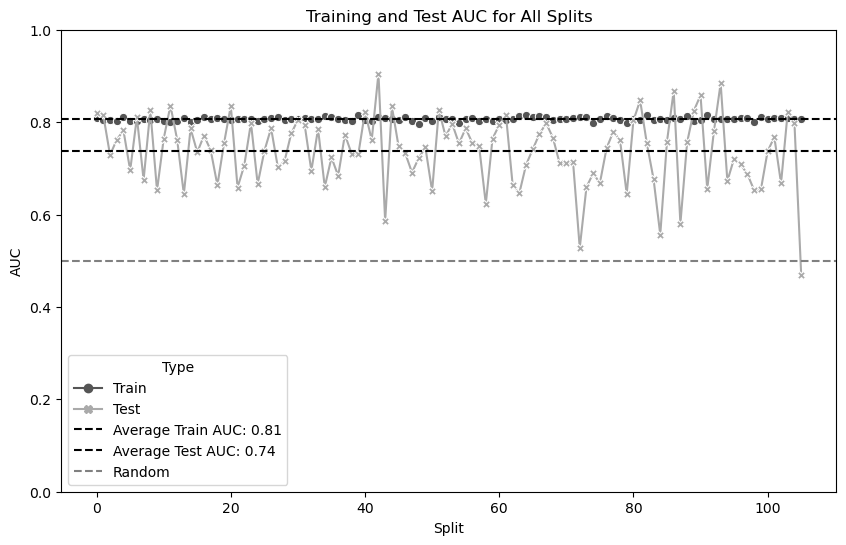

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_aucs' and 'test_aucs' are lists of AUC scores
splits = np.arange(len(train_aucs))  # Assuming splits are sequential and equal to the length of AUC lists

# Prepare a DataFrame for Seaborn
data = pd.DataFrame({
    'Split': np.concatenate([splits, splits]),  # Double the splits for train and test
    'AUC': np.concatenate([train_aucs, test_aucs]),  # Combine AUC scores
    'Type': ['Train']*len(train_aucs) + ['Test']*len(test_aucs)  # Label types
})

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Set the color palette to black and white
palette = sns.color_palette("gray", n_colors=2)

# Draw a line plot with Seaborn
sns.lineplot(data=data, x='Split', y='AUC', hue='Type', style='Type', markers=True, dashes=False, palette=palette)

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='black', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='black', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random chance performance
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

# Customize the axes and title
plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')

# Show the legend and customize it to not show the color guide
plt.legend(title='Type')

# Set the ylim to standardize the AUC view
plt.ylim([0, 1])

# Display the plot
plt.show()


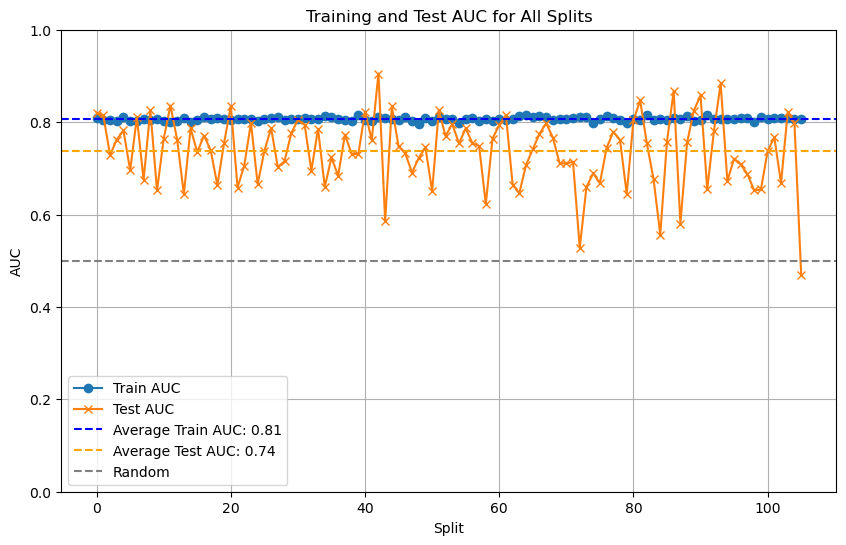

In [20]:
import matplotlib.pyplot as plt

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

plt.figure(figsize=(10, 6))
plt.plot(train_aucs, label="Train AUC", marker='o')
plt.plot(test_aucs, label="Test AUC", marker='x')

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='blue', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='orange', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()
